In [1]:
import requests
import time
import calendar
import dateutil.parser as parser
from dateutil.relativedelta import relativedelta
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import warnings
import yaml
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from pycaret.datasets import get_data
from pycaret.classification import *

### Get Candlestick Data

In [2]:
now = datetime.now()

In [4]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    k_number = cfg['knn']['k_number']
    metric = cfg['knn']['metric']
    algorithm = cfg['knn']['algorithm']
    feature_1 = cfg['knn']['feature_1']
    feature_2 = cfg['knn']['feature_2']
    feature_3 = cfg['knn']['feature_3']
    feature_7 = cfg['knn']['feature_7']
    feature_8 = cfg['knn']['feature_8']
    feature_9 = cfg['knn']['feature_9']
    feature_10 = cfg['knn']['feature_10']
    feature_11 = cfg['knn']['feature_11']
    feature_12 = cfg['knn']['feature_12']
    feature_13 = cfg['knn']['feature_13']
    feature_14 = cfg['knn']['feature_14']
    volume = cfg['feature']['volume']
    volume_size = cfg['sample']['volume_size']
    sample_count = cfg['sample']['count']
    candles = cfg['recommendation']['candle_count']
    pair = cfg['currency']['pair']
    instrument = cfg['currency']['instrument']
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']
    model = cfg['model']['name']

In [4]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)
print('Future Candle Count:', candles)
print('Pair:', pair)

K Number: 5
Metric: euclidean
Algorithm: brute
Candle Volume Size: 1000
Random Sample Count: 10000
Future Candle Count: 7
Pair: EURGBP


In [5]:
with open ('config.yml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    oanda_api_key = cfg['creds']['oanda_api']
    account_number = cfg['creds']['account_number'] 

In [6]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [7]:
print('Instrument:', instrument)

Instrument: EUR_GBP


In [8]:
Load_10K_Records=True
Load_20K_Records=True

currency_pairs = [instrument]


timeframe = "H4"
#D #H1 #H4 M30
# https://developer.oanda.com/rest-live-v20/instrument-df/#CandlestickGranularity
price_char = "M"
#M(midpoint candles) #B(bid candles) #A(ask candles) #BA
price_com = "mid"
#mid #bid #ask

# def of OANDA request variable
provider_api_url = 'https://api-fxpractice.oanda.com/v3/accounts/{}/orders'.format(account_number)
request_headers = {
    "Authorization": oanda_api_key,
    "Accept-Datetime-Format": "RFC3339",
    "Connection": "Keep-Alive",
    "Content-Type": "application/json;charset=UTF-8"
}


In [9]:
provider_authorization = 'Bearer {0}'.format(oanda_api_key)

headers = {
    'Content-Type': 'application/json',
    'Authorization': provider_authorization,
}

In [10]:
params_count = (
    ('price', price_char),
    ('count', '5000'),
    ('granularity', timeframe),
)


In [11]:
for pair in currency_pairs:
    first_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair), 
                            headers=headers,
                            params=params_count).json()

In [12]:
if Load_10K_Records:
    
    #### Load 10K data
        
    datetime_object = parser.parse(first_response['candles'][0]['time'])
    date= datetime_object - relativedelta(years=3)  
    from_date = date.replace(tzinfo=timezone.utc).timestamp()
    params_date = (
        ('count', '5000'),
        ('price', price_char),
        ('from', from_date),
        ('granularity', timeframe),)

    second_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                   headers=headers,
                                   params=params_date).json()
    datetime_object_15K = parser.parse(second_response['candles'][0]['time'])
    first_response= first_response['candles']  
    second_response= second_response['candles']
    second_response.extend(first_response)
    
    if Load_20K_Records:

        #### Load 15K data

        date= datetime_object_15K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        third_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(third_response['candles'][0]['time'])
        third_response= third_response['candles']
        third_response.extend(second_response)

        #### Load 20K data

        date= datetime_object_20K - relativedelta(years=3)  
        from_date = date.replace(tzinfo=timezone.utc).timestamp()
        params_date = (
            ('count', '5000'),
            ('price', price_char),
            ('from', from_date),
            ('granularity', timeframe),)

        fourth_response = requests.get('https://api-fxpractice.oanda.com/v3/instruments/{}/candles'.format(pair),
                                       headers=headers,
                                       params=params_date).json()
        datetime_object_20K = parser.parse(fourth_response['candles'][0]['time'])
        fourth_response= fourth_response['candles']
        fourth_response.extend(third_response)

        response=fourth_response
    else:
       response=second_response 
else:
    response=first_response['candles']

In [13]:
filename = "{}_{}.csv".format(pair, timeframe)
output = []
all_candlesticks = response

for i in range (len(all_candlesticks)):
    result= (convert_date(response[i]['time']))
    output.append([(result[0]),(result[1]),(result[2]),(result[3]),(result[4]),(result[5]),
                    response[i]['time'],
                    response[i]['volume'], 
                    response[i][price_com]['o'],
                    response[i][price_com]['h'],
                    response[i][price_com]['l'],
                    response[i][price_com]['c']])
    
output = pd.DataFrame(output)
output.columns = ['Date','Time','f_time','julian_date','Weekday','Weekday_Name','UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close']
data = output.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [14]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [15]:
data.shape

(19341, 12)

In [16]:
data['SMA_5'] = data['Close'].rolling(window=5).mean().round(4)
data['SMA_10'] = data['Close'].rolling(window=10).mean().round(4)
data['SMA_20'] = data['Close'].rolling(window=20).mean().round(4)

In [17]:
data['F_SMA_5'] = data['Close'] - data['SMA_5']
data['F_SMA_10'] = data['Close'] - data['SMA_10']
data['F_SMA_20'] = data['Close'] - data['SMA_20']

In [18]:
data = data.drop_duplicates()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [19]:
data['O-H'] = data['Open'] - data['High']
data['O-L'] = data['Open'] - data['Low']
data['O-C'] = data['Open'] - data['Close']
data['H-L'] = data['High'] - data['Low']
data['H-C'] = data['High'] - data['Close']
data['L-C'] = data['Low'] - data['Close']

data['Direction'] = data['O-C'].apply(lambda x: 1 if x<0 else 0)

data['col_1'] = data['Open'] - data['Close']

for value in data['col_1']:   
    if value > 0:
        data['col_2'] = data['High'] - data['Open']
        data['col_3'] = data['Close'] - data['Low']
    else:
        data['col_2'] = data['High'] - data['Close']
        data['col_3'] = data['Open'] - data['Low']

#Two Previous Candlesticks 
data['col_4'] = data['col_1'].shift(1)
data['col_5'] = data['col_1'].shift(2)

In [20]:
data = data.dropna()
data = data.to_csv(filename, header = True, index = False)
data = pd.read_csv(filename)

In [21]:
data.shape

(19322, 30)

### Generating Training Data

In [22]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_f_time=var_time.hour
    var_julian_date=parsed_date.timetuple().tm_yday
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_f_time, var_julian_date, var_weekday, var_weekday_name

In [23]:
print('K Number:',k_number)
print('Metric:', metric)
print('Algorithm:', algorithm)

K Number: 5
Metric: euclidean
Algorithm: brute


In [224]:
def find_k_similar_candles(candle_id, dataset, k = k_number):
    indices=[]
    distances = []
    output = []
    model_knn = NearestNeighbors(metric = metric, algorithm = algorithm) 
    model_knn.fit(dataset)
    
    #metric = 'euclidean' or 'cosine' or 'manhattan' or 'mahalanobis'
    
    distances, indices = model_knn.kneighbors(dataset.iloc[candle_id,:].values.reshape(1,-1),
                                              n_neighbors = k)

    for i in range(0,len(distances.flatten())):
        if i!=0:
            
            output.append ([dataset.index[indices.flatten()[i]],
                            distances.flatten()[i],
                            dataset.iloc[indices.flatten()[i]][feature_9],
                            dataset.iloc[indices.flatten()[i]][feature_10],
                            dataset.iloc[indices.flatten()[i]][feature_11],
                            dataset.iloc[indices.flatten()[i]][feature_12],
                            dataset.iloc[indices.flatten()[i]][feature_13],
                            dataset.iloc[indices.flatten()[i]][feature_14],
                           ])
    
    output = pd.DataFrame(output)
    output.columns = ['Indice','Distance',
                      feature_9,
                      feature_10,
                      feature_11,
                      feature_12,
                      feature_13,
                      feature_14,
                     ]
   # display (output)
    
    return indices, distances

# <font color='red'>Test Configs</font>

In [25]:
filename = '{}_H4.csv'.format(instrument)
data = pd.read_csv(filename)

In [26]:
data.columns

Index(['Date', 'Time', 'f_time', 'julian_date', 'Weekday', 'Weekday_Name',
       'UTC_Time', 'Volume', 'Open', 'High', 'Low', 'Close', 'SMA_5', 'SMA_10',
       'SMA_20', 'F_SMA_5', 'F_SMA_10', 'F_SMA_20', 'O-H', 'O-L', 'O-C', 'H-L',
       'H-C', 'L-C', 'Direction', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5'],
      dtype='object')

## Selecting n random candles where their volume is more than x

In [27]:
print('Candle Volume Size:', volume_size)
print('Random Sample Count:', sample_count)

Candle Volume Size: 1000
Random Sample Count: 10000


In [28]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)

In [29]:
#Random_Candles = np.random.randint(low=1, high=len(data)-40, size=1000)
Random_Candles = list(random_samples.index.values)

# <font color='red'>CANDLE LOOP</font>

In [30]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [31]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
                              'Rec1_Score':[],
                              'Rec1_Prediction':[],
                              'Rec2_Score':[],
                              'Rec2_Prediction':[],
                              'Rec3_Score':[],
                              'Rec3_Prediction':[],
                              'Rec4_Score':[],
                              'Rec4_Prediction':[]
                             })

for candle_no in Random_Candles:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    #print(Current_Market_Fit)
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market='Bullish'
    else:
        Current_Market = 'Bearish'
    
    data = pd.read_csv(filename)
    data = data[[feature_9,
                 feature_10,
                 feature_11,
                 feature_12,
                 feature_13,
                 feature_14,
                ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade= 'BUY'
        else:
            Predicted_Trade = 'SELL'
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
              'Rec1_Score': predicted_output[0][0],
              'Rec1_Prediction': predicted_output[0][1],
              'Rec2_Score': predicted_output[1][0],
              'Rec2_Prediction': predicted_output[1][1],
              'Rec3_Score': predicted_output[2][0],
              'Rec3_Prediction': predicted_output[2][1],
              'Rec4_Score': predicted_output[3][0],
              'Rec4_Prediction': predicted_output[3][1],
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 03-02-2022_05-51_AM
CPU times: user 5h 47min 47s, sys: 6h 54min 28s, total: 12h 42min 15s
Wall time: 2h 16min 34s


In [32]:
result_output.to_csv('01_Back_Test_Data.csv', header = True, index = False)
result_output.to_csv(today + "_" + "Back_Test_Data_" + pair + '.csv', header = True, index = False)
result_output = pd.read_csv(today + "_" + "Back_Test_Data_" + pair + '.csv')
result_output.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,3569.0,15.326543,Bullish,30.282301,BUY,92.631041,SELL,29.089686,BUY,87.410771,BUY
1,14128.0,63.559312,Bearish,0.013307,SELL,19.762834,BUY,52.041391,SELL,40.216717,BUY
2,1090.0,63.330255,Bullish,8.992931,SELL,58.237507,SELL,0.023307,BUY,19.603445,SELL
3,14024.0,80.269313,Bearish,68.519067,BUY,68.951383,BUY,78.235354,SELL,2.322186,SELL
4,14455.0,71.814373,Bullish,55.674258,BUY,3.616220,SELL,17.064516,BUY,87.365404,BUY


In [33]:
result_output.shape

(10000, 11)

#### Generating Log File

In [34]:
file = open(today + "_" + "data_generation_log_" + pair + '.txt', "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "K_Number: " + str(k_number) + "\n" + \
            "KNN_Metric: " + metric + "\n" + \
            "KNN_Algorithm: " + algorithm + "\n" + \
            "Feature: " + feature_9 + "\n" + \
            "Feature: " + feature_10 + "\n" + \
            "Feature: " + feature_11 + "\n" + \
            "Feature: " + feature_12 + "\n" + \
            "Feature: " + feature_13 + "\n" + \
            "Feature: " + feature_14 + "\n" + \
            "Volume Size: " + str(volume_size) + "\n" + \
            "Sample Count: " + str(sample_count) + "\n" + \
            "Candle Counts: " + str(candles) + "\n"
           )
file.close()

### Modeling

In [181]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    random_state = cfg['model']['random_state']

In [182]:
print('Pair:', pair)
print('Fraction:', frac)
print('Random State:', random_state)

Pair: EURGBP
Fraction: 0.7
Random State: 4950


In [183]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [184]:
dataset = pd.read_csv('01_Back_Test_Data.csv')
dataset.shape

(10000, 11)

In [185]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,3569.0,15.326543,Bullish,30.282301,BUY,92.631041,SELL,29.089686,BUY,87.410771,BUY
1,14128.0,63.559312,Bearish,0.013307,SELL,19.762834,BUY,52.041391,SELL,40.216717,BUY
2,1090.0,63.330255,Bullish,8.992931,SELL,58.237507,SELL,0.023307,BUY,19.603445,SELL
3,14024.0,80.269313,Bearish,68.519067,BUY,68.951383,BUY,78.235354,SELL,2.322186,SELL
4,14455.0,71.814373,Bullish,55.674258,BUY,3.616220,SELL,17.064516,BUY,87.365404,BUY


In [186]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [187]:
dataset.shape

(7287, 11)

In [188]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [189]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [190]:
dataset['Rec1_Score'] = dataset['Rec1_Score'].round(2)
dataset['Rec2_Score'] = dataset['Rec2_Score'].round(2)
dataset['Rec3_Score'] = dataset['Rec3_Score'].round(2)
dataset['Rec4_Score'] = dataset['Rec4_Score'].round(2)

In [191]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [192]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,0,-0.01,19.76,-52.04,40.22
1,1,-8.99,-58.24,0.02,-19.60
2,0,68.52,68.95,-78.24,-2.32
3,1,55.67,-3.62,17.06,87.37
4,1,21.96,1.06,-12.66,11.39


In [193]:
data = dataset.sample(frac=frac, random_state=random_state).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print('Fraction: ' + str(frac))
#print('Random State: ', str(random_state))

Data for Modeling: (5101, 5)
Unseen Data For Predictions: (2186, 5)
Fraction: 0.7


In [194]:
data_unseen.shape

(2186, 5)

In [195]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,70.44,-94.74,-16.50,-20.54
1,1,26.45,75.47,57.36,15.40
2,1,0.44,77.95,-53.30,-82.40
3,0,53.65,-71.94,-82.95,49.65
4,1,-21.48,-20.10,-27.02,-82.71


In [196]:
exp_name = setup(data = data,
                 target = 'Current_Market',
#                 fold_shuffle=True,
                 session_id=123,
                 silent=True,
#                 n_jobs = 64,
#                 imputation_type='iterative'
                ) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5101, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [197]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5098,0.5065,0.5330,0.5115,0.5217,0.0195,0.0194,0.0550
lr,Logistic Regression,0.5081,0.5122,0.5402,0.5090,0.5240,0.0161,0.0161,0.0080
ridge,Ridge Classifier,0.5081,0.0000,0.5402,0.5090,0.5240,0.0161,0.0161,0.0050
lda,Linear Discriminant Analysis,0.5081,0.5122,0.5402,0.5090,0.5240,0.0161,0.0161,0.0050
svm,SVM - Linear Kernel,0.5076,0.0000,0.5034,0.5087,0.5057,0.0152,0.0152,0.0090
nb,Naive Bayes,0.5064,0.5048,0.5385,0.5073,0.5222,0.0127,0.0128,0.0050
lightgbm,Light Gradient Boosting Machine,0.5056,0.5065,0.5028,0.5074,0.5048,0.0112,0.0112,0.0180
dt,Decision Tree Classifier,0.5022,0.5022,0.5140,0.5032,0.5083,0.0044,0.0044,0.0110
qda,Quadratic Discriminant Analysis,0.5022,0.4984,0.5575,0.5034,0.5288,0.0042,0.0042,0.0060
ada,Ada Boost Classifier,0.4994,0.5005,0.5073,0.5013,0.5039,-0.0012,-0.0012,0.0290


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [198]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    model = cfg['model']['name']

In [199]:
print('Model Name:', model)

Model Name: gbc


In [200]:
MODEL = create_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4818,0.4980,0.5363,0.4848,0.5093,-0.0367,-0.0369
1,0.5714,0.5670,0.5866,0.5707,0.5785,0.1428,0.1428
2,0.4902,0.4760,0.5363,0.4923,0.5134,-0.0199,-0.0200
3,0.4874,0.4815,0.5419,0.4899,0.5146,-0.0255,-0.0257
4,0.5070,0.5047,0.5475,0.5078,0.5269,0.0138,0.0138
5,0.5070,0.5012,0.5196,0.5082,0.5138,0.0139,0.0139
6,0.5630,0.5454,0.5475,0.5665,0.5568,0.1261,0.1262
7,0.5070,0.5175,0.5084,0.5084,0.5084,0.0140,0.0140
8,0.4762,0.4397,0.4860,0.4780,0.4820,-0.0477,-0.0477
9,0.5070,0.5336,0.5196,0.5082,0.5138,0.0139,0.0139


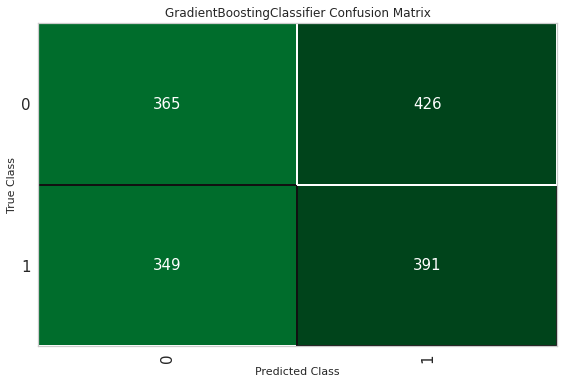

In [201]:
plot_model(MODEL, plot = 'confusion_matrix')

In [202]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5434,0.5487,0.4860,0.5506,0.5163,0.0871,0.0877
1,0.5546,0.5631,0.4972,0.5633,0.5282,0.1095,0.1103
2,0.5154,0.5298,0.5363,0.5161,0.5260,0.0307,0.0307
3,0.4734,0.4555,0.4749,0.4749,0.4749,-0.0532,-0.0532
4,0.4790,0.4825,0.4972,0.4811,0.4890,-0.0421,-0.0421
5,0.4902,0.4673,0.4972,0.4917,0.4944,-0.0196,-0.0196
6,0.4958,0.4931,0.4916,0.4972,0.4944,-0.0084,-0.0084
7,0.5154,0.5058,0.5140,0.5169,0.5154,0.0308,0.0308
8,0.5294,0.5120,0.5587,0.5291,0.5435,0.0587,0.0588
9,0.5182,0.5341,0.5307,0.5191,0.5249,0.0363,0.0364


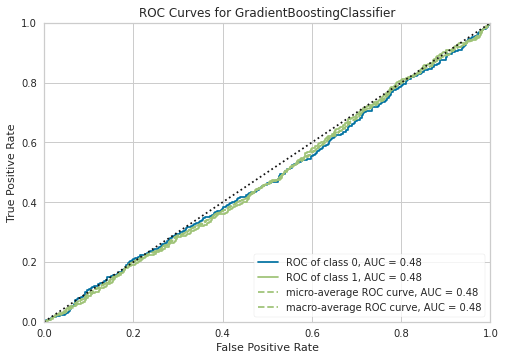

In [203]:
plot_model(TUNED_MODEL, plot = 'auc')

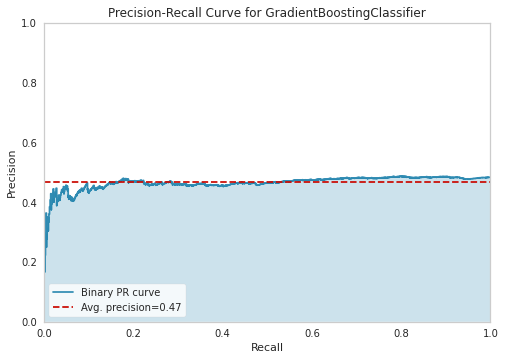

In [204]:
plot_model(TUNED_MODEL, plot = 'pr')

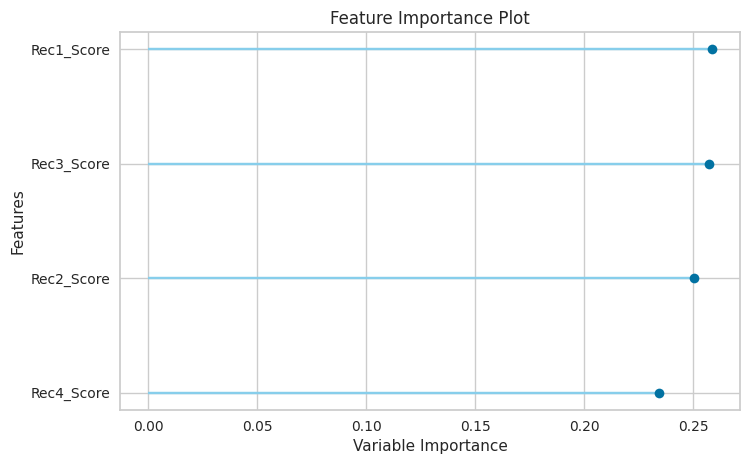

In [205]:
plot_model(TUNED_MODEL, plot='feature')

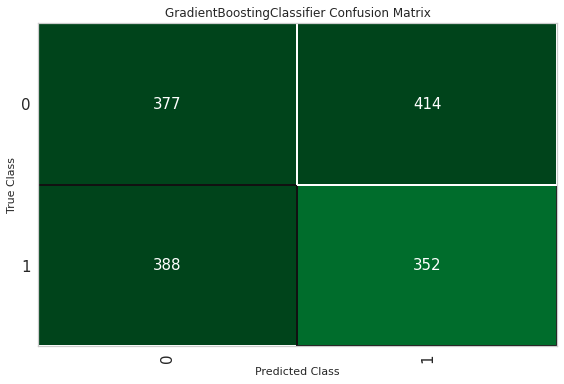

In [206]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [207]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.4762,0.4822,0.4757,0.4595,0.4675,-0.0477,-0.0477


In [208]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [209]:
print(FINAL_MODEL)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=5,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0005,
                           min_impurity_split=None, min_samples_leaf=3,
                           min_samples_split=7, min_weight_fraction_leaf=0.0,
                           n_estimators=160, n_iter_no_change=None,
                           presort='deprecated', random_state=123,
                           subsample=0.45, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)


In [210]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8850,0.9499,0.8676,0.8917,0.8795,0.7696,0.7699


In [211]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,70.44,-94.74,-16.50,-20.54,1,0.9627
1,1,26.45,75.47,57.36,15.40,1,0.7809
2,1,0.44,77.95,-53.30,-82.40,1,0.9114
3,0,53.65,-71.94,-82.95,49.65,0,0.8820
4,1,-21.48,-20.10,-27.02,-82.71,1,0.7959


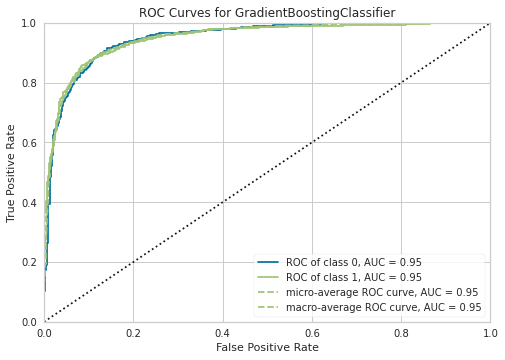

In [212]:
plot_model(FINAL_MODEL, plot = 'auc')

In [213]:
pkl_name = (today + "_" + model + "_" + pair)

In [214]:
save_model(FINAL_MODEL, pkl_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                             learning_rate=0.3, loss='deviance',
                                             max_depth=5, max_features=1.0,
                                             max_leaf_nodes=None,
            

In [215]:
SAVED_FINAL_MODEL = load_model(pkl_name)

Transformation Pipeline and Model Successfully Loaded


In [216]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [217]:
data_unseen.shape

(2186, 5)

In [218]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,70.44,-94.74,-16.50,-20.54,1,0.9627
1,1,26.45,75.47,57.36,15.40,1,0.7809
2,1,0.44,77.95,-53.30,-82.40,1,0.9114
3,0,53.65,-71.94,-82.95,49.65,0,0.8820
4,1,-21.48,-20.10,-27.02,-82.71,1,0.7959
5,1,-66.68,77.86,21.30,50.66,1,0.5360
6,0,-0.05,-64.31,24.95,-33.77,0,0.8829
7,0,-41.66,73.37,25.05,-56.78,0,0.8463
8,0,-81.67,-46.05,-33.52,-65.30,1,0.5923
9,1,48.42,-8.66,56.36,63.29,0,0.5517


In [219]:
file = open(today + "_" + model + "_binary_classification_log_" + pair + ".txt", "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "Model: " + model + "\n" + \
            "Frac: " + str(frac) + "\n" + \
            "Random State: " + str(random_state) + "\n" )
file.close()

### Final Test

In [220]:
filename = '{}_H4.csv'.format(instrument)
data = pd.read_csv(filename)

In [221]:
random_samples = data[data[volume] > volume_size].sample(n = sample_count)
Test_Candle = list(random_samples.index.values)

In [228]:
#LR_FINAL_MODEL = load_model('FINAL_MODELS/EURUSD/FINAL_LR_25Nov2021_EURUSD')
#ET_FINAL_MODEL = load_model('FINAL_MODELS/EURUSD/FINAL_ET_25Nov2021_EURUSD')
#KNN_FINAL_MODEL = load_model('03-02-2022_06-41_PM_gbc_EURGBP')
#DT_FINAL_MODEL = load_model('FINAL_MODELS/USDCAD/10-01-2022_06-15_AM_dt_USDCAD')
GBC_FINAL_MODEL = load_model('03-02-2022_06-41_PM_gbc_EURGBP')
#LIGHTGBM_FINAL_MODEL = load_model('FINAL_MODELS/GBPUSD/09-01-2022_10-58_PM_lightgbm_GBPUSD')

Transformation Pipeline and Model Successfully Loaded


In [229]:
%%time
print ('Today: ' + today)

result_output = pd.DataFrame({'Candle_No':[],
                              'Current_Market_Fit':[],
                              'Current_Market':[],
#                              'Rec1':[],
#                              'Rec1_P':[],
#                              'Rec2':[],
#                              'Rec2_P':[],
#                              'Rec3':[],
#                              'Rec3_P':[],
#                              'LR_Label':[],
#                              'LR_Score':[],
#                              'ET_Label':[],
#                              'ET_Score':[],
#                              'KNN_Label':[],
#                              'KNN_Score':[],
#                              'DT_Label':[],
#                              'DT_Score':[],
#                              'LIGHTGBM_Label':[],
#                              'LIGHTGBM_Score':[],
                              'GBC_Label':[],
                              'GBC_Score':[],                              
                             })

for candle_no in Test_Candle:
    data = pd.read_csv(filename)
    data = data.iloc[candle_no:candle_no+candles]
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X) 
    
    Current_Market_Fit = r2_score(Y, y_pred)*100
    coeficient = (linear_regressor.coef_)

    if coeficient > 0:
        Current_Market= 1

    else:
        Current_Market = 0

    data = pd.read_csv(filename)
    data = data[[feature_9,
                 feature_10,
                 feature_11,
                 feature_12,
                 feature_13,
                 feature_14,
                ]]

    indices, distances = find_k_similar_candles (candle_no,data)
    indices = indices[0:1][0]
    
    predicted_output = []
    recs = []
    for indice in indices[1:5]:
             
        Predicted_Market_Fit =0
        Predicted_Trade=''
    
        data = pd.read_csv(filename) 
        data = data.iloc[indice:indice+candles]

        data['candleno'] = range (1, len(data) + 1)
        X = data['candleno'].values.reshape(-1, 1)
        Y = data['Close'].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        y_pred = linear_regressor.predict(X)

        Predicted_Market_Fit= r2_score(Y, y_pred)*100
        coeficient = (linear_regressor.coef_)

        if coeficient > 0:
            Predicted_Trade = 'BUY'
            recs.append((r2_score(Y, y_pred)*100))
        else:
            Predicted_Trade = 'SELL'
            recs.append((r2_score(Y, y_pred)*100) * -1)
        
        predicted_output.append([Predicted_Market_Fit,Predicted_Trade])
        
        
    data_unseen = pd.DataFrame ({
        'Rec1_Score': [recs[0]],
        'Rec2_Score': [recs[1]],
        'Rec3_Score': [recs[2]],
        'Rec4_Score': [recs[3]],
    })
    
#    lr_prediction = predict_model(LR_FINAL_MODEL, data=data_unseen)
#    LR_Label = lr_prediction['Label']
#    LR_Score = lr_prediction['Score']
    
#    et_prediction = predict_model(ET_FINAL_MODEL, data=data_unseen)
#    ET_Label = et_prediction['Label']
#    ET_Score = et_prediction['Score']
    
#    knn_prediction = predict_model(KNN_FINAL_MODEL, data=data_unseen)
#    KNN_Label = knn_prediction['Label']
#    KNN_Score = knn_prediction['Score']
    
#    dt_prediction = predict_model(DT_FINAL_MODEL, data=data_unseen)
#    DT_Label = dt_prediction['Label']
#    DT_Score = dt_prediction['Score']
    
#    lightgbm_prediction = predict_model(LIGHTGBM_FINAL_MODEL, data=data_unseen)
#    LIGHTGBM_Label = lightgbm_prediction['Label']
#    LIGHTGBM_Score = lightgbm_prediction['Score']

    gbc_prediction = predict_model(GBC_FINAL_MODEL, data=data_unseen)
    GBC_Label = gbc_prediction['Label']
    GBC_Score = gbc_prediction['Score']    
    
    result = {'Candle_No': candle_no,
              'Current_Market_Fit': Current_Market_Fit,
              'Current_Market': Current_Market,
#              'Rec1': predicted_output[0][0],
#              'Rec1_P': predicted_output[0][1],
#              'Rec2': predicted_output[1][0],
#              'Rec2_P': predicted_output[1][1],
#              'Rec3': predicted_output[2][0],
#              'Rec3_P': predicted_output[2][1],
#              'LR_Label': LR_Label[0],
#              'LR_Score': LR_Score[0],
#              'ET_Label': ET_Label[0],
#              'ET_Score': ET_Score[0],
#              'KNN_Label': KNN_Label[0],
#              'KNN_Score': KNN_Score[0],
#              'DT_Label': DT_Label[0],
#              'DT_Score': DT_Score[0],
#              'LIGHTGBM_Label': LIGHTGBM_Label[0],
#              'LIGHTGBM_Score': LIGHTGBM_Score[0],
              'GBC_Label': GBC_Label[0],
              'GBC_Score': GBC_Score[0],              
             }
    
    result_output = result_output.append(result, ignore_index = True)

Today: 03-02-2022_06-41_PM


/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=F

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=F

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=F

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/mladmin/Data/Forex

/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mladmin/Data/Forexience/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalar

CPU times: user 7h 51min 29s, sys: 9h 9min 26s, total: 17h 56s
Wall time: 2h 32min 26s


In [230]:
result_output.to_csv('03_Back_Test_Final_Result_' + today + '.csv', header = True, index = False)
result_output = pd.read_csv('03_Back_Test_Final_Result_' + today + '.csv')

In [231]:
result_output = result_output[result_output['Current_Market_Fit'] > 20]
result_output = result_output.reset_index()
del result_output['index']

In [232]:
result_output.shape

(7315, 5)

In [233]:
result_output.to_csv('03_Back_Test_Final_Result_' + today + '.csv', header = True, index = False)
result_output = pd.read_csv('03_Back_Test_Final_Result_' + today + '.csv')

In [234]:
#result_output['LR_Prediction'] = result_output['Current_Market'] - result_output['LR_Label']
#result_output['ET_Prediction'] = result_output['Current_Market'] - result_output['ET_Label']
#result_output['KNN_Prediction'] = result_output['Current_Market'] - result_output['KNN_Label']
#result_output['DT_Prediction'] = result_output['Current_Market'] - result_output['DT_Label']
#result_output['LIGHTGBM_Prediction'] = result_output['Current_Market'] - result_output['LIGHTGBM_Label']
result_output['GBC_Prediction'] = result_output['Current_Market'] - result_output['GBC_Label']

In [235]:
GBC_Result = pd.DataFrame(result_output['GBC_Prediction'].value_counts())
GBC_Result["Score"] = (GBC_Result['GBC_Prediction'] * 100 / len(result_output)).round(2)

In [237]:
result = pd.concat([
#    LR_Result,
#    ET_Result,
#    KNN_Result,
#    DT_Result,
    GBC_Result,
#    LIGHTGBM_Result,
], axis=1)
result

,GBC_Prediction,Score
0.0,4831,66.04
1.0,1245,17.02
-1.0,1239,16.94
